# Poço Quântico

Neste documento demonstramos a utilização do software e indicamos os resultados, que podem ser visualizados no modo abaixo ou acessados na pasta **results**.

## Inicialização

Para utilizar o módulo, basta importar as bibliotecas abaixo:

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from quantum_well import QuantumWell
warnings.filterwarnings('error')

e instanciar um dispositivo.

In [2]:
device = QuantumWell(well_length=100.0, well_height=1.0, N=2048, dt=1e-19)

que foi iniciado com as seguintes propriedades:

- **well_length=100.0**, largura de 100.0 Angstrom
- **well_height=1.0**, altura de 1.0 eV
- **N=2048**, 2048 pontos na malha (discretização)
- **dt=1e-19**, passo de tempo de $1 \times 10^{-19}$ segundos

## Calculo dos Autoestados e Autovalores

O comando abaxo solicita o cálculo dos primeiros **3** autoestados e autovalores com precisao de 0.01 %

In [3]:
device.numerical_solution(precision=1e-4)

KeyboardInterrupt: 

os autoestados são mostrados à seguir:

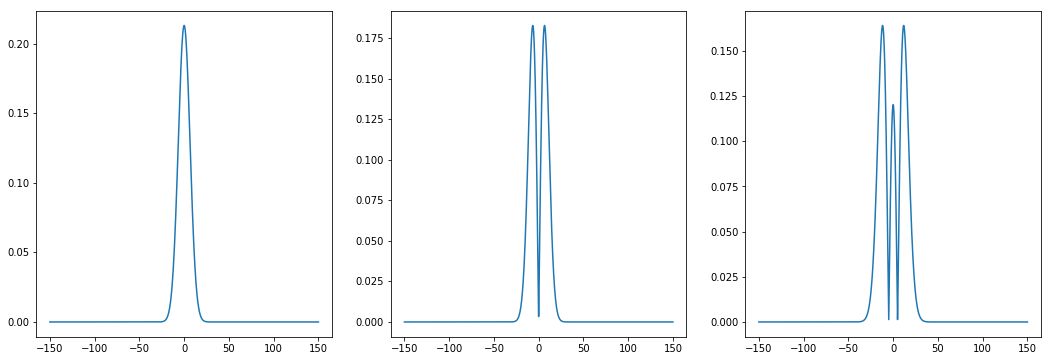

In [3]:
n = [0,1,2]
fix, axs = plt.subplots(1,3, figsize=(18,6))
for i, ax in enumerate(list(axs)):
    ax.plot(device.z_ang, np.abs(device.eigenstates[0])**2)
    ax.set_xlabel(r'z (A)')
    ax.set_ylabel(r'|psi_{%d} (z)|^2$' % i)
plt.show()

In [ ]:
este é o perfil do potencial:

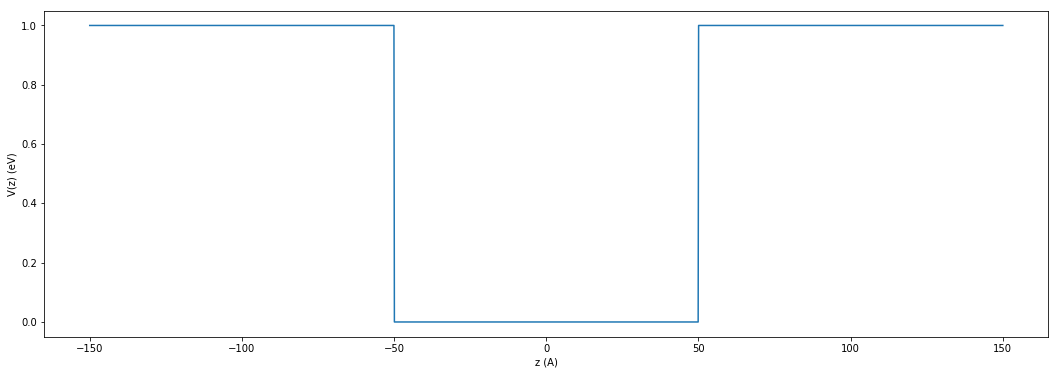

In [5]:
fix, ax = plt.subplots(1,1, figsize=(18,6))
ax.plot(device.z_ang, device.v_ev)
ax.set_xlabel(r'z (A)')
ax.set_ylabel('V(z) (eV)')
plt.show()

In [5]:
#!/usr/bin/env python
"""
This module just solves the analytical expression for a
very specific case of quantum well, which is one made
of GaAs surrounded by AlGaAs with concentration x=0.4
"""

# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import simps
import scipy.constants as cte
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.fftpack import fft, ifft, fftfreq
import scipy.special as sp
from scipy.signal import gaussian
from scipy.optimize import newton, fsolve

# matplotlib defaults setup
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "computer modern sans serif"
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.unicode']=True

# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

# grandezas de interesse em unidades atomicas
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')

# outras relacoes de interesse
ev = cte.value('electron volt')
c = cte.value('speed of light in vacuum')
hbar_si = cte.value('Planck constant over 2 pi')
me = cte.value('electron mass')
au2ang = au_l / 1e-10
au2ev = au_e / ev

# constantes do problema
E0 = 150.0 # eV
delta_x = 5.0 # angstron
x0 = -30.0 # angstron
xf = -40.0 # angstron
l = 8.1e-6 # m

# otimizando
L = 100 # angstron
N = 2048
hN = int(N/2)
dt = 1e-19 # s

# unidades atomicas
L_au = L / au2ang
dt_au = -1j * dt / au_t
E0_au = E0 / au2ev
delta_x_au = delta_x / au2ang
x0_au = x0 / au2ang
xf_au = xf / au2ang
k0_au = np.sqrt(2 * E0_au)

# malhas direta e reciproca
dx = L / (N-1)
x_au = np.linspace(-L_au/2.0, L_au/2.0, N)
dx_au = np.abs(x_au[1] - x_au[0])
k_au = fftfreq(N, d=dx_au)

# props do material
eg = lambda x: 0.7 * (1.519 + 1.447 * x - 0.15 * x**2) # eV
Vb_au = (eg(0.4)-eg(0.0)) / au2ev
me_eff = 0.067

valores = []
#poco_a = np.linspace(10,500,200)
poco_a = [300]
series = []
for a in poco_a:
    autovalores = []
    a_au = a / au2ang
    v_au = np.vectorize(lambda x: Vb_au if np.abs(x) > a_au/2 else 0.0)(x_au)
    f = lambda e: np.tan(np.sqrt(2*me_eff*e)*a_au/2)-np.sqrt(2*me_eff*(Vb_au-e)) / np.sqrt(2*me_eff*e)
    for e0 in np.linspace(-Vb_au, Vb_au, 1000):
        try:
            root = newton(f, x0=e0)
            if root > 0:
                autovalores.append(root * au2ev)
        except:
            pass
    f = lambda e: 1.0/np.tan(np.sqrt(2*me_eff*e)*a_au/2)+np.sqrt(2*me_eff*(Vb_au-e)) / np.sqrt(2*me_eff*e)
    for e0 in np.linspace(-Vb_au, Vb_au, 1000):
        try:
            root = newton(f, x0=e0)
            if root > 0:
                autovalores.append(root * au2ev)
        except:
            pass
    autovalores = list(sorted(set(autovalores)))
    offset = [0]
    for i, v in enumerate(autovalores):
        if i > 0:
            if np.abs(autovalores[i] / np.average(autovalores[offset[-1]:i])-1.0) > 0.01:
                offset.append(i)
        offset.append(len(autovalores))
    autovalores = [np.average(autovalores[offset[i]:offset[i+1]]) for i in range(len(offset)-1)]
    for i, av in enumerate(autovalores):
        series.append((a, av))

/home/thiago/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/thiago/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in sqrt


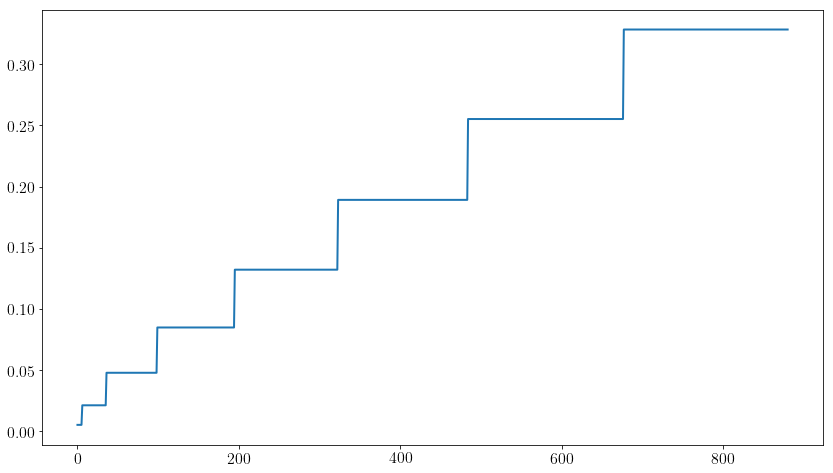

In [6]:
plt.plot(autovalores)
plt.show()

In [33]:
offset = [0]
for i, v in enumerate(autovalores):
    if i > 0:
        if np.abs(autovalores[i] / np.average(autovalores[offset[-1]:i])-1.0) > 0.01:
            offset.append(i)
offset.append(len(autovalores))
autovalores = [np.average(autovalores[offset[i]:offset[i+1]]) for i in range(len(offset)-1)]

In [5]:
device.analytical_solution(3)

/home/euzi/Documents/thiago/softwares/quantum-modules/algaas_quantum_well.py:111: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*self.m_eff*e)*self.wl_au/2) - \
/home/euzi/Documents/thiago/softwares/quantum-modules/algaas_quantum_well.py:113: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*self.m_eff*e)
/home/euzi/Documents/thiago/softwares/quantum-modules/algaas_quantum_well.py:112: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*self.m_eff*(self.vb_au-e)) / \
/home/euzi/Documents/thiago/softwares/quantum-modules/algaas_quantum_well.py:116: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*self.m_eff*e)*self.wl_au/2)+\
/home/euzi/Documents/thiago/softwares/quantum-modules/algaas_quantum_well.py:118: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*self.m_eff*e)
/home/euzi/Documents/thiago/softwares/quantum-modules/algaas_quantum_well.py:117: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*self.m_eff*(sel

[0.036154145904711041, 0.14144815303864428, 0.30078354116166955]